# Importing Libraries

In [18]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras import layers,models
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import os
import seaborn as sns
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

# Preparing the Data

In [9]:
df = pd.read_csv('dataset/train.csv')

In [10]:
# Analysis of Dataframe

df.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [11]:
df['Class'].value_counts()

Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: Class, dtype: int64

/Users/sparshbohra/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Class', ylabel='count'>

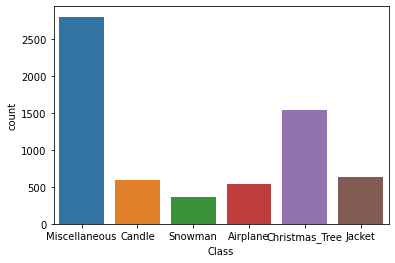

In [12]:
sns.countplot(df['Class'])

In [13]:
# Data Augmentation

datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input)

In [14]:
train_generator = datagen.flow_from_dataframe(
    df,
    directory = 'dataset/train',
    x_col = 'Image',
    y_col = 'Class',
    target_size = (299, 299),
    class_mode = 'categorical',
    batch_size = 32)

Found 6469 validated image filenames belonging to 6 classes.


# Building the Model

In [21]:
holidayModel = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (299,299,3))

In [22]:
holidayModel.trainable = False

In [23]:
model = models.Sequential()
model.add(holidayModel)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(6,activation='softmax'))

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 22,984,742
Trainable params: 1,181,958
Non-trainable params: 21,802,784
__________________________________

In [25]:
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [26]:
train_steps = np.ceil(train_generator.n/train_generator.batch_size)

In [27]:
model.fit(
    train_generator,
    epochs = 12,
    batch_size = 32,
    steps_per_epoch = train_steps)

Epoch 1/12
203/203 [==============================] - 604s 3s/step - loss: 0.6285 - accuracy: 0.7853
Epoch 2/12
203/203 [==============================] - 641s 3s/step - loss: 0.3890 - accuracy: 0.8607
Epoch 3/12
203/203 [==============================] - 649s 3s/step - loss: 0.3317 - accuracy: 0.8851
Epoch 4/12
203/203 [==============================] - 702s 3s/step - loss: 0.3172 - accuracy: 0.8915
Epoch 5/12
203/203 [==============================] - 721s 4s/step - loss: 0.2780 - accuracy: 0.9025
Epoch 6/12
203/203 [==============================] - 691s 3s/step - loss: 0.2506 - accuracy: 0.9097
Epoch 7/12
203/203 [==============================] - 770s 4s/step - loss: 0.2478 - accuracy: 0.9091
Epoch 8/12
203/203 [==============================] - 868s 4s/step - loss: 0.2278 - accuracy: 0.9161
Epoch 9/12
203/203 [==============================] - 789s 4s/step - loss: 0.2068 - accuracy: 0.9236
Epoch 10/12
203/203 [==============================] - 627s 3s/step - loss: 0.2191 - accura

# Test Data Prediction

In [28]:
test_df = pd.DataFrame()
test_images = os.listdir('dataset/test')
test_df['Image'] = test_images
test_df.head()

,Image
0,image8799.jpg
1,image1965.jpg
2,image4821.jpg
3,image1795.jpg
4,image444.jpg


In [29]:
# Data Augmentation

test_generator = datagen.flow_from_dataframe(
    test_df,
    directory = 'dataset/test',
    x_col = 'Image',
    y_col = None,
    target_size = (299, 299),
    class_mode = None,
    batch_size = 32,
    shuffle = False )

Found 3489 validated image filenames.


In [30]:
test_steps = np.ceil(test_generator.n / test_generator.batch_size)

In [31]:
pred = model.predict_generator(
    test_generator,
    steps = test_steps,
    verbose = 1 )

Instructions for updating:
Please use Model.predict, which supports generators.
110/110 [==============================] - 354s 3s/step


In [32]:
pred = np.argmax(pred,axis = -1)

In [33]:
# Dataframe for submission

test_df['Class'] = pred

In [34]:
num_to_class = dict((y,x) for (x,y) in train_generator.class_indices.items())
num_to_class

{0: 'Airplane',
 1: 'Candle',
 2: 'Christmas_Tree',
 3: 'Jacket',
 4: 'Miscellaneous',
 5: 'Snowman'}

In [35]:
test_df['Class'] = test_df['Class'].map(num_to_class)
test_df.head()

,Image,Class
0,image8799.jpg,Jacket
1,image1965.jpg,Miscellaneous
2,image4821.jpg,Miscellaneous
3,image1795.jpg,Miscellaneous
4,image444.jpg,Miscellaneous


In [36]:
test_df.shape

(3489, 2)

In [37]:
# Save submission file

test_df.to_csv('attempt2.csv', index = False)